In [1]:
# import relevant modules

import numpy as np
import matplotlib.pyplot as plt

## The ocean recharge oscillator ##

This report describes the process of modelling the ocean recharge oscillator (ROM), a reduced coupled model for ENSO illustrating the effects of nonlinearity and forcing, based on the model of Fei-Fei Jin (1997a).

![frame_0_delay-0.01s.jpg](attachment:5c0a97dc-f0b6-4f07-9e4c-1661e58cfa71.jpg)

Figure 3 from Fei-Fei Jin (1997), where (a) shows the time series for SST (in $^{\circ}C$, solid line) and thermocline depth in the Western Pacific (in 10 m, dashed line) and (b) shows the phase space plot of SST against thermocline depth, with initial conditions of SST at $1.125^{\circ}C$ and themocline depth in the western Pacific at zero.

### Governing equations ###

Jin's (1997b) ROM is described by two ordinary differential equations

$$ \frac{dh_w}{dt} = -rh_w - \alpha b T_e - \alpha \xi_1 $$

$$ \frac{dT_E}{dt} = R T_E + \gamma h_w - e_n(h_w + bT_E)^3 + \gamma \xi_1 + \xi_2 $$

where the prognostic variables are $T_E$ (east Pacific SST anomaly) and $h_W$ (west Pacific
ocean thermocline depth) and other variables are defined in the cell below.

For Task A, we consider the neutrial linear (deterministic) ROM, without external forcing ($\xi_{1,2} = 0$) or nonlinearity ($e_n = 0$). The ODEs above reduce to:

$$ \frac{dh_w}{dt} = -rh_w - \alpha b T_e $$

$$ \frac{dT_E}{dt} = R T_E + \gamma h_w $$

In [2]:
# define the global variables

# non-dimensionalised parameters

T_nd = 7.5 # SST anomaly-scale (kelvin)
h_nd = 150 # thermocline depth scale (m)
t_nd = 2*30*24*60*60 # time-scale - 2 months in seconds

# define the variables for Task A - neutral linear (deterministic) ROM

mu_c = 2/3 # critical value for the coupling parameter
mu = mu_c # set the coupling value to its critical parameter
b_0 = 2.5 # high end value for the coupling parameter
b = b_0*mu # measure of the thermocline slope
gamma = 0.75 # feedback of the thermocline gradient on the SST gradient
c = 1 # damping rate of SST anomalies
R = gamma*b - c # describes the Bjerknes positive feedback process
r = 0.25 # damping of upper ocean heat content
alpha = 0.125 # relates enhanced easterly wind stress to the recharge of ocean heat content
e_n = 0 # degree of nonlinearity of ROM
xi_1 = 0 # random wind stress forcing added to the system
xi_2 = 0 # random heating added to the system

dt = 0.1 # time interval - two months split into 10 equal slices

The most simple time scheme is the explicit euler. The consistency condition forces us to choose $$\alpha_n = 1$$
Given this consistency condition, the scheme reduces to 
$$ \frac{q^{n+1} - q^n}{\Delta t} = f^n$$
Where the truncation error is given by
$$ \frac{\Delta t}{2}q'' + O(\Delta t^2) = O(\Delta t)$$
Therefore the scheme has first order accuracy

For the neutral linear (deterministic) ROM in task A, the explict euler scheme is given by the following coupled equations:

$$ T_E^{N+1} = T_E^N + \Delta{t}(RT_E^N + \gamma h_w^N) $$

$$ h_w^{N+1} = h_w^N - \Delta t(rh_w^N + \alpha b T_e^N) $$

In [3]:
# write a function for the simple explicit euler function

def euler(T_init, h_init, mu, R, gamma, e_n, xi_1, xi_2, dt, nt):
    """Explicit euler scheme for solving the ocean recharge oscillator model using finite differences. Takes T, the SST anomaly, h, the thermocline depth scale, t, the time scale, mu, the coupling value, R, the bjerkness positive feedback, gamma, the feedback of the thermocline gradient on the SST gradient, e_n, the degree of nonlinearity xi_1 and xi_2, the random wind stress and random heating added to the system, dt, the time step size and nt, the number of time steps."""

    # initialize arrays to store the results
    time = np.zeros(nt)
    T_e = np.zeros(nt)
    h_w = np.zeros(nt)

    # set the initial conditions
    T_e[0] = T_init
    h_w[0] = h_init

    # step forward in time with the explicit euler scheme
    for i in range(1,nt):

        time[i] = i * dt
        
        # for T - SST anomaly scale
        T_e[i] = T_e[i-1] + dt*(R*T_e[i-1] + gamma*h_w[i-1])

        # for h - thermocline depth scale
        h_w[i] = h_w[i-1] + dt*(r*h_w[i-1] - alpha*b*T_e[i-1])
    
    return T_e, h_w, time

The explicit euler method can be modified to obtain better accuracy through proper choice of the $\alpha$ 's, if we use $l > 0$. If we consider the case $l=1$. This scheme is known as Adams-Bashforth, and reduces to

$$ \frac{q^{n+1} - q^n}{\Delta t} = \alpha_n f^n + \alpha_{n-1}f^{n+1} $$

The consistency condition reduces to

$$ \alpha_n + \alpha_{n+1} = 1 $$

And the truncation error is

$$ \varepsilon = \Delta t q'' \biggl( \alpha_{n-1} + \frac{1}{2} \biggr) + O(\Delta t^2) $$

Giving second order accuracy

For the neutral linear (deterministic) ROM in task A, the Adams-Bashforth scheme is given by the following coupled equations:

$$ T_E^{N+1} = T_E^N + \Delta{t} \biggl(\frac{3}{2}(RT_E^N + \gamma h_w^N) - \frac{1}{2} (RT_E^{N-1} + \gamma h_w^{N-1}) \biggr) $$

$$ h_w^{N+1} = h_w^N + \Delta t \biggl(-\frac{3}{2}(rh_w^N + \alpha b T_e^N) + \frac{1}{2}(rh_w^{N-1} + \alpha b T_e^{N-1}) \biggr) $$

In [4]:
def adams_bashforth(T_init, h_init, mu, R, gamma, e_n, xi_1, xi_2, dt, nt):
    """Modified euler scheme to give Adams-Bashforth time scheme for modelling the ocean recharge oscillator model using finite difference. Should give second order accuracy. Takes T, the SST anomaly, h, the thermocline depth scale, t, the time scale, mu, the coupling value, R, the bjerknes positive feedback, gamma, the feedback of the thermocline gradient on  the SST gradient, e_n, the degree of nonlinearity xi_1 and xi_2, the random wind stress and random heating added to the system, dt, the size of the timestep and nt, the number of timesteps."""

    # initialize arrays to store the results
    time = np.zeros(nt)
    T_e = np.zeros(nt)
    h_w = np.zeros(nt)

    # set the initial conditions
    T_e[0] = T_init
    h_w[0] = h_init
    
    # calculate the 1th value using the explicit euler
    T_e[1] = T_e[0] + dt*(R*T_e[0] + gamma*h_w[0])
    h_w[1] = h_w[0] + dt*(r*h_w[0] + alpha*b*T_e[0])
    
    # step forward in time with the Adams-Bashforth scheme
    for i in range(2,nt):
        
        # time variable
        time[i] = i * dt
        
        # for T - SST anomaly scale
        T_e[i] = T_e[i-1] + dt*(3/2*(R*T_e[i-1] + gamma*h_w[i-1]) - 1/2*(R*T_e[i-2] + gamma*h_w[i-2]))

        # for h - thermocline depth scale
        h_w[i] = h_w[i-1] + dt*(-3/2*(r*h_w[i-1] + alpha*b*T_e[i-1]) + 1/2*(r*h_w[i-2] + alpha*b*T_e[i-2]))
    
    return T_e, h_w, time

The trapezoidal implicit scheme has second order accuracy and is given by

$$ \frac{q^{n+1} - q^n}{\Delta t} = \beta f^{n+1} + \alpha_n f^n $$

With coefficients

$$ \beta = \alpha = \frac{1}{2} $$

And truncation error

$$ \varepsilon = \Delta t q''\biggl(\frac{1}{2} - \beta \biggr) + O(\Delta t^2) $$

For the neutral linear (deterministic) ROM in task A, the trapezoidal scheme is given by the following coupled equations:

$$ T_e^{n+1} = T_e^{n} + \frac{\Delta t}{2} \biggl((RT_e^{n+1} + \gamma h_w^{n+1}) + (RT_e^{n} + \gamma h_w^{n})\biggr) $$

$$ h_w^{n+1} = h_w^{n} - \frac{\Delta t}{2} \biggl((rh_w^{n+1} + \alpha b T_e^{n+1}) + (rh_w^{n} + \alpha b T_e^{n+1}) \biggr) $$


In [5]:
def trapezoidal(T_init, h_init, mu, R, gamma, e_n, xi_1, xi_2, dt, nt):
    """Implicit trapezoidal finite difference scheme for modelling the ocean recharge oscillator model. Takes T_init, the initial SST anomaly, h_init, the initial thermocline depth scale, mu, the coupling value, R, the bjerknes positive feedback, gamma, the feedback of the thermocline gradient on the SST gradient, e_n, the degree of nonlinearity xi_1 and xi_2, the random wind stress and random heating added to the system, dt, the size of the time steps and nt the number of time steps."""
    
    # initialize arrays to store the results
    time = np.zeros(nt)
    T_e = np.zeros(nt)
    h_w = np.zeros(nt)

    # set the initial conditions
    T_e[0] = T_init
    h_w[0] = h_init

    # step forward in time with the general implementation of the implicit trapezoidal scheme
    for i in range(1,nt):
        
        # time variable
        time[i] = i * dt
        
        # for T - SST anomaly scale
        T_e[i] = T_e[i-1] + dt/2*((R*T_e[i] + gamma*h_w[i]) + (R*T_e[i-1] + gamma*h_w[i-1]))

        # for h - thermocline depth scale
        h_w[i] = h_w[i-1] - dt/2*((r*h_w[i] + alpha*b*T_e[i]) + (r*h_w[i-1] + alpha*b*T_e[i-1]))
    
    return T_e, h_w, time

One example of an iterative "predictor-corrector" time schemes is the fourth order accurate Runge-Kutta, which is given by

$$ q^{n+1} = q^n + \Delta t \frac{1}{6} \bigl(k_1 + 2k_2 + 2k_3 + k_4 \bigr) $$

Where the $k$'s are given by

$$ k_1 = f(q^n,n \Delta t) $$

$$ k_2 = f \biggl[q^n + \frac{k_1 \Delta t}{2}, \biggl(n+\frac{1}{2} \biggr) \Delta t \biggr] $$

$$ k_3 = f \biggl[q^n + \frac{k_2 \Delta t}{2}, \biggl(n+\frac{1}{2} \biggr) \Delta t \biggr] $$

$$ k_4 = f \bigl[q^n + k_3 \Delta t,(n+1) \Delta t \bigr] $$

Each of the $k$'s can be interpreted as an approximation to $f$. Each of the $k$'s have to be evaluated successively, which means that the function $f$ has to be evaluated four times to take one time step. None of these $f$'s can be "re-used" on the next timestep. For this reason, long time steps should be used with this scheme.

Let's consider the simple implementation of the four step Runge-Kutte for Task A where K and l represent the components of T and h respectively.

$$ k_1 = f(T_e,h_w,t) $$

$$ l_1 = f(T_e,h_w,t) $$

Where $k$ and $l$ are approximations to a coupled set of functions $f$ which can be expressed as a function of T_e, the temperature, h_w, the thermocline depth and t, the timestep. For the simple ROM, $k_1$ and $l_1$ are given by:

$$ k_1 =  R T_E + \gamma h_w $$

$$ l_1 = -rh_w - \alpha b T_e $$

Thus, it follows that $k_2$, $k_3$ and $k_4$ (and their $l$'s) are given by the following:

$$ k_2 = R \biggl(T_e + \frac{k_1 \Delta t}{2} \biggr) + \gamma \biggl(h_w + \frac{l_1 \Delta t}{2} \biggr) $$

$$ l_2 = -r \biggl(h_w + \frac{l_1 \Delta t}{2} \biggr) - \alpha b \biggl(T_e + \frac{k_1 \Delta t}{2} \biggr) $$

$$ k_3 = R \biggl(T_e + \frac{k_2 \Delta t}{2} \biggr) + \gamma \biggl(h_w + \frac{l_2 \Delta t}{2} \biggr) $$

$$ l_3 = -r \biggl(h_w + \frac{l_2 \Delta t}{2} \biggr) - \alpha b \biggl(T_e + \frac{k_2 \Delta t}{2} \biggr) $$

$$ k_4 = R (T_e + k_3 \Delta t) + \gamma (h_w + l_3 \Delta t ) $$

$$ l_4 = -r (h_w + l_3 \Delta t) - \alpha b (T_e + k_3 \Delta t) $$


In [36]:
def runge_kutta(T_e, h_w, mu, R, gamma, e_n, xi_1, xi_2, dt, nt):
    """Fourth-order iterative Runge Kutta scheme for simple set of coupled ODEs in task 1"""
    # need to fill in the parameters here

    k_1 = R*T_e + gamma * h_w
    l_1 = -r*h_w - alpha*b*T_e

    k_2 = R*(T_e + dt/2*k_1) + gamma*(h_w + dt/2*l_1)
    l_2 = -r*(h_w + dt/2*l_1) - alpha*b*(T_e + dt/2*k_1)

    k_3 = R*(T_e + dt/2*k_2) + gamma*(h_w + dt/2*l_2)
    l_3 = -r*(h_w + dt/2*l_2) - alpha*b*(T_e + dt/2*k_2)

    k_4 = R*(T_e + dt*k_3) + gamma*(h_w + dt*l_3)
    l_4 = -r*(h_w + dt*l_3) - alpha*b*(T_e + dt*k_3)

    T_e_next = T_e + dt/6*(k_1 + 2*k_2 + 2*k_3 + k_4)
    h_w_next = h_w + dt/6*(l_1 + 2*l_2 + 2*l_3 + l_4)

    return T_e_next, h_w_next

# initial conditions
T_e = 1.125
h_w = 0

dt = 10
nt = 1000

T_e_test, h_w_test = runge_kutta(T_e, h_w, mu, R, gamma, e_n, xi_1, xi_2, dt, nt)

print(T_e_test)
print(h_w_test)

T_e_test2, h_w_test2 = runge_kutta(T_e_test, h_w_test, mu, R, gamma, e_n, xi_1, xi_2, dt, nt)

print(T_e_test2)
print(h_w_test2)

T_e_test3, h_w_test3 = runge_kutta(T_e_test2, h_w_test2, mu, R, gamma, e_n, xi_1, xi_2, dt, nt)

print(T_e_test3)
print(h_w_test3)

T_e_test4, h_w_test4 = runge_kutta(T_e_test3, h_w_test3, mu, R, gamma, e_n, xi_1, xi_2, dt, nt)

print(T_e_test4)
print(h_w_test4)

T_e_test5, h_w_test5 = runge_kutta(T_e_test4, h_w_test4, mu, R, gamma, e_n, xi_1, xi_2, dt, nt)

print(T_e_test5)
print(h_w_test5)






-1.6105957031250018
1.3183593749999998
-3.2560343742370557
-0.06694793701172208
4.943907695822427
-3.908110968768594
9.409444045902974
0.3970901612774602
-15.146166472668364
11.57501791321279


/tmp/ipykernel_6336/3463457972.py:14: RuntimeWarning: overflow encountered in double_scalars
  k_4 = R*(T_e + dt*k_3) + gamma*(h_w + dt*l_3)
/tmp/ipykernel_6336/3463457972.py:14: RuntimeWarning: invalid value encountered in double_scalars
  k_4 = R*(T_e + dt*k_3) + gamma*(h_w + dt*l_3)
/tmp/ipykernel_6336/3463457972.py:15: RuntimeWarning: overflow encountered in double_scalars
  l_4 = -r*(h_w + dt*l_3) - alpha*b*(T_e + dt*k_3)
/tmp/ipykernel_6336/3463457972.py:15: RuntimeWarning: invalid value encountered in double_scalars
  l_4 = -r*(h_w + dt*l_3) - alpha*b*(T_e + dt*k_3)


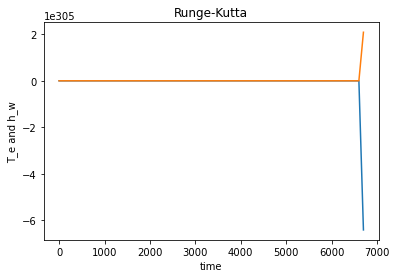

In [34]:
# define the number of time steps
nt = 1000
dt = 100

mu=2/3

# initialize T_e and h_w as arrays
T_e = np.zeros(nt)
h_w = np.zeros(nt)
time = np.zeros(nt)

# define the initial conditions for a run of this function
T_e[0] = 1.125
h_w[0] = 0

# write a for loop to run the function nt times
for i in range(1,nt-1):

    time[i] = i * dt
    
    T_e[i], h_w[i] = runge_kutta(T_e[i-1], h_w[i-1], mu, R, gamma, e_n, xi_1, xi_2, dt, nt)

#print(T_e)



# plot the results as a time series with time on the x-axis and T_e and h_w on the y-axis
#\\ plot time on the x-axis and T_e on the y-axis
plt.plot(time, T_e)
#\\ plot time on the x-axis and h_w on the y-axis
plt.plot(time, h_w)
#\\ label the x-axis as 'time'
plt.xlabel('time')
#\\ label the y-axis as 'T_e and h_w'
plt.ylabel('T_e and h_w')
#\\ title the plot 'Runge-Kutta'
plt.title('Runge-Kutta')
#\\ save the plot as a .png file
plt.savefig('Runge-Kutta.png')

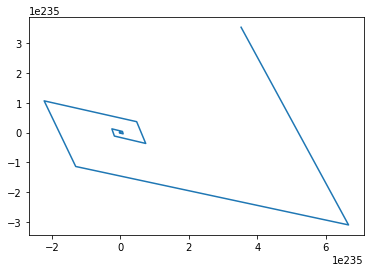

In [29]:
# phase space attempt

plt.plot(T_e,h_w)

In [28]:
# code for the Runge-Kutta function
def runge_kutta_implement(T_init, h_init, mu, R, gamma, e_n, xi_1, xi_2, dt, nt):
    """Fourth-order iterative Runge-Kutta scheme for modelling the ocean recharge oscillator model. Takes T, the initial SST anomaly, h, the initial thermocline depth scale, mu, the coupling value, R, the bjerknes positive feedback, gamma, the feedback of the thermocline gradient on the SST gradient , e_n, the degree of nonlinearity xi_1 and xi_2, the random wind stress and random heating added to the system, dt, the time step size and nt, the number of time steps."""

    # initialize arrays to store the results
    time = np.zeros(nt)
    T_e = np.zeros(nt)
    h_w = np.zeros(nt)

    # set the initial conditions
    T_e = T_init
    h_w = h_init

    # create empty lists to store T_e and h_w values
    T_e_list = []
    h_w_list = []

    # append initial values to lists
    T_e_list.append(T_e)
    h_w_list.append(h_w)
    
    # step forward in time with the implementation of the Runge-Kutta scheme
    for i in range(1,nt):

        # time variable
        time[i] = i * dt

        # implement RK4O scheme
        # not completely sure about the ordering of these
        
        T_e, h_w = runge_kutta(T_e, h_w, mu, R, gamma, e_n, xi_1, xi_2, dt, nt)

        T_e_list.append(T_e)
        h_w_list.append(h_w)
        
    return T_e_list, h_w_list, time        

In [30]:
# try the new runge-kutte scheme
# define f in the first instance

#def f(T, h):
    """Function to calculate the derivative of the system of equations
    for the ocean recharge oscillator model. Takes T, the SST anomaly, h, the thermocline
    depth scale, t, the time scale, mu, the coupling value, R, the bjerknes
    positive feedback, gamma, the feedback of the thermocline gradient on
    the SST gradient and dt, the time step size, e_n, the degree of nonlinearity
    xi_1 and xi_2, the random wind stress and random heating added to the system."""

    # calculate the derivative of T
    dTdt = R*T + gamma*h + xi_1 + xi_2

    # calculate the derivative of h
    dhdt = r*h + alpha*b*T + xi_1 + xi_2

    return dTdt, dhdt

In [34]:
# now implement the runge kutte scheme

#def runge_kutta():
    """Runge-Kutta scheme for solving the ocean recharge oscillator
    model using finite differences. Takes T, the SST anomaly, h, the thermocline
    depth scale, t, the time scale, mu, the coupling value, R, the bjerknes
    positive feedback, gamma, the feedback of the thermocline gradient on
    the SST gradient and dt, the time step size, e_n, the degree of nonlinearity
    xi_1 and xi_2, the random wind stress and random heating added to the system."""

    # specify the initial conditions
    T = 1.125
    h = 0

    # specify the timestep
    dt = 1

    # specify the number of time steps
    nt = 100

    # initialize arrays to store the results
    time = np.zeros(nt)
    T_e = np.zeros(nt)
    h_w = np.zeros(nt)

    # set the initial conditions
    T_e[0] = T
    h_w[0] = h

    # loop over all time steps
    for n in range(1, nt):
        #\\ the time stepping schme for the four step runge-kutta method
        time[n] = n * int(dt)
        k1 = int(dt) * f(T_e[n-1], h_w[n-1])
        k2 = int(dt) * f(T_e[n-1] + 0.5*k1, h_w[n-1] + 0.5*k1)
        k3 = int(dt) * f(T_e[n-1] + 0.5*k2, h_w[n-1] + 0.5*k2)
        k4 = int(dt) * f(T_e[n-1] + k3, h_w[n-1] + k3)
        T_e[n] = T_e[n-1] + (1/6)*(k1 + 2*k2 + 2*k3 + k4)

    return T_e, h_w, time

Now we want to try to run this explict euler code to generate two plots, one for phase space and the other for the time series. First plot the time series, which is simply how the SST anomaly (T) and thermocline depth (h) vary with time. Then plot the phase space, which is the SST anomaly (T) plotted against the thermocline depth (h) or vice versa.

In [35]:
# plot the time series
# x-axis is just time
# then need two y-axes - one for SST anomaly and one for thermocline depth

# set the initial conditions
T_init = 1.125 # initial SST in kelvin
h_init = 0 # initial depth anomaly

# set standard dt and nt for all of the implementations
dt = 1 # size of time step
nt = 100 # number of time steps

# run each of the implmentations
sst_anomaly, thermocline_depth, time = euler(T_init, h_init, mu, R, gamma, e_n, xi_1, xi_2, dt, nt)
sst_anomaly_ab, thermocline_depth_ab, time_ab = adams_bashforth(T_init, h_init, mu, R, gamma, e_n, xi_1, xi_2, dt, nt)
sst_anomaly_tz, thermocline_depth_tz, time_tz = trapezoidal(T_init, h_init, mu, R, gamma, e_n, xi_1, xi_2, dt, nt)
sst_anomaly_rk, thermocline_depth_rk, time_rk = runge_kutta()

#print(sst_anomaly_rk)

#print(thermocline_depth_rk)

# quick euler time series plot
plt.plot(time, sst_anomaly_rk, 'r-')
plt.plot(time, thermocline_depth_rk, 'b-')

# gather the data
#data = [(sst_anomaly, thermocline_depth, time), (sst_anomaly_ab, thermocline_depth_ab, time_ab), (sst_anomaly_tz, thermocline_depth_tz, time_tz)] 
        
        #(sst_anomaly_rk, thermocline_depth_rk, time_rk)] 

# set up the subplot labels
#sp_labels = ['Explicit Euler', 'Adams-Bashforth', 'Trapezoidal'] # 'Runge-Kutta']

# Create the figure and axes
#fig, axes = plt.subplots(3,1)

#for i, ax in enumerate(axes.flat):
#    sst_anomaly, thermocline_depth, time = data[i]
#    ax.plot(time, sst_anomaly, 'r-')
#    ax.set_ylabel('SST Anomaly (T)', color='r')
#    ax.tick_params(axis='y', labelcolor='r')
#    #ax.set_ylim(np.min(sst_anomaly),np.max(sst_anomaly))
#    ax2 = ax.twinx()
#    ax2.plot(time, thermocline_depth, 'b-.')
#    ax2.set_ylabel('Thermocline Depth (h)', color='b')
#    ax2.tick_params(axis='y', labelcolor='b')
#    #ax2.set_ylim(np.min(thermocline_depth),np.max(thermocline_depth))
#    plt.xlabel('Time')
#    ax.set_title(sp_labels[i])

# ensure that labels don't overlap
plt.tight_layout()

# Show the plot
plt.show()


TypeError: can't multiply sequence by non-int of type 'float'

Time series appears to show an exponential increase - explicit euler is unstable?

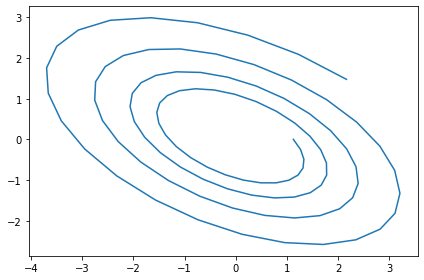

In [19]:
# now write up the code for the phase space plot
# Create the phase space plot

#fig, axes = plt.subplots(nrows=2, ncols=2)

#for i, ax in enumerate(axes.flat):
    #sst_anomaly, thermocline_depth, time = data[i]
    #ax.plot(sst_anomaly, thermocline_depth)
    #ax.set_xlabel('SST Anomaly (K)')
    #ax.set_ylabel('Thermocline Depth (m)')
    #ax.set_title(sp_labels[i])

# quick euler phase space plot
plt.plot(sst_anomaly_rk, thermocline_depth_rk)
    
# specify tight layout
plt.tight_layout()

# Show the plot
plt.show()

Phase space plot not showing any cycles either - instabilty of tyhe explicit euler scehme?

In [ ]:
nt = 10


k_list = ['k_'+str(i) for i in range(1,5)]
l_list = ['l_'+str(i) for i in range(1,5)]

for k,l in zip(k_list,l_list):
    exec(f"{k} = np.zeros(nt)")
    exec(f"{l} = np.zeros(nt)")


print(k_1)
print(k_2)
print(k_3)
print(k_4)

print(l_1)
print(l_2)
print(l_3)
print(l_4)

# References #

Jin, F.-F., 1997a. An Equatorial Ocean Recharge Paradigm for ENSO. Part I: Conceptual Model. J. Atmos. Sci. 54, 811–829. https://doi.org/10.1175/1520-0469(1997)054<0811:AEORPF>2.0.CO;2

Jin, F.-F., 1997b. An Equatorial Ocean Recharge Paradigm for ENSO. Part II: A Stripped-Down Coupled Model. Journal of the Atmospheric Sciences 54, 830–847. https://doi.org/10.1175/1520-0469(1997)054<0830:AEORPF>2.0.CO;2

